In [1]:
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.tree import export_graphviz
from graphviz import Digraph

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

import os
import random

import itertools
import sys
import time
import threading

In [2]:
MIN_INFO_GAIN = -1000000
TITANIC_DS_TARGET = "survived"
FEATURES = ['pclass','sex','age','sibsp', 'parch', 'fare']
UNKNOWN = 9999
TARGET = "survived"
TREES_OUTPUT_DIR = "output/trees"
CM_OUTPUT_DIR = "output/cm"
TREE_DEFAULT_START_DEPTH = 0
TREE_DEFAULT_MAX_DEPTH = 6
GLOBAL_DEFAULT_CLASS = 0
EXECUTION_DONE = False

### Entropie

L'entropie $H(S)$ d'un ensemble de données $S$ est définie comme :

$$
H(S) = -\sum_{i=1}^{n} p_i \log_2(p_i)
$$

Où :

- $n$ est le nombre de classes distinctes dans l'ensemble de données
- $p_i$ est la proportion d'exemples dans la classe $i$

---

### Gain d'Information

Le gain d'information $IG(S, A)$ d'un ensemble de données $S$ après la division sur l'attribut $A$ est :

$$
IG(S, A) = H(S) - \sum_{v=1}^{k} \frac{|S_v|}{|S|} H(S_v)
$$

Où :

- $k$ est le nombre de sous-ensembles en divisant l'ensemble des données $S$ selon l'attribut $A$.
- $S_v$ est le sous-ensemble de rang $v$ dans la subdivision de $S$ selon l'attribut $A$
- $|S_v|$ est le nombre d'échantillons dans $S_v$
- $|S|$ est le nombre total d'échantillons dans $S$

In [3]:
def spinner():
    for c in itertools.cycle(['|', '/', '-', '\\']):
        if EXECUTION_DONE:
            break
        sys.stdout.write('\rTraitement en cours ' + c)
        sys.stdout.flush()
        time.sleep(0.1)

def entropy(data_col:pd.DataFrame):
    val_counts = data_col.value_counts()
    N = data_col.shape[0]
    #print(val_counts)
    entropy = 0.0
    for val, count in val_counts.items():
        """print(val)
        print(count)"""
        p = count/N
        entropy -= p*np.log2(p)

    return entropy

def feature_info_gain(data:pd.DataFrame, target:str, col:str):

    entropy_dataset = entropy(data[target])

    #pd.api.types.is_integer_dtype(df['A'])
    #pd.api.types.is_float_dtype(df['B'])
    thresholds = None

    if (pd.api.types.is_float_dtype(data[col])):
        #print(f"float col - mean : {col} - {data[col].mean()}")
        thresholds = [data[col].median()]
    else:
        thresholds = data[col].unique()

    
    """data_left = pd.DataFrame([],columns=data.columns)
    data_right = pd.DataFrame([],columns=data.columns)"""

    data_left = None
    data_right = None

    info_gain = MIN_INFO_GAIN
    best_threshold = None

    if (len(thresholds) == 1) and not pd.api.types.is_float_dtype(data[col]):
        return info_gain, best_threshold, data_left, data_right

    for thres in thresholds:
        
        current_data_left = data[data[col] <= thres]
        current_data_right = data[data[col] > thres]

        left_weight = current_data_left.shape[0]/data.shape[0]
        right_weight = current_data_right.shape[0]/data.shape[0]

        left_entropy = entropy(current_data_left[target])
        right_entropy = entropy(current_data_right[target])

        current_info_gain = entropy_dataset - (left_weight*left_entropy+right_weight*right_entropy)

        if current_info_gain > info_gain:
            info_gain = current_info_gain
            best_threshold = thres
            data_left = current_data_left
            data_right = current_data_right

        #print(f"Split: {col} - {thres} - {current_data_left.shape} - {current_data_right.shape}")
    #print(f"Feature Split: {col} - {best_threshold} - {len(data_left)} - {len(data_right)}")
    return info_gain, best_threshold, data_left, data_right


def best_info_gain_feature_and_data_split(data:pd.DataFrame,target_col_name:str,features:list):
    
    feat_igain, thres, data_left, data_right = MIN_INFO_GAIN, None, None, None

    target_feat = ""
    for feat in features:
        
        
        current_feat_igain, current_thres, current_data_left, current_data_right = feature_info_gain(data, target_col_name, feat)
        if current_feat_igain > feat_igain:
            target_feat = feat
            feat_igain, thres, data_left, data_right = current_feat_igain, current_thres, current_data_left, current_data_right
    #print(f"best split: {target_feat} - {thres} - {data_left.shape} - {data_right.shape}")
    return target_feat, thres, data_left, data_right

def visualize_tree(node, graph=None, node_id=0):
    if graph is None:
        graph = Digraph()
    
    current_id = str(node_id)
    #print(node_id)
    if node.leaf_val is not None:
        graph.node(current_id, label=f"Leaf\nValue={node.leaf_val}")
    else:
        graph.node(current_id, label=f"X[{node.discriminant_feat}] <= {node.threshold}")
        left_id = str(2 * node_id + 1)
        right_id = str(2 * node_id + 2)
        if (node.left is not None):
            graph.edge(current_id, left_id, label="True")
            visualize_tree(node.left, graph, 2 * node_id + 1)
        
        if (node.right is not None):
            graph.edge(current_id, right_id, label="False")        
            visualize_tree(node.right, graph, 2 * node_id + 2)
    
    return graph


#data are dataframe columns, series or numpy arrays
def display_cm(y_test, y_pred, y_all, cm_title, pred_axis_label, true_axis_label, show=True, save=True):
    # Calculate and display the confusion matrix
    class_labels = np.unique(y_all) # Use all unique target labels
    #class_labels = np.append(class_labels, UNKNOWN)
    cm = confusion_matrix(y_test, y_pred, labels=class_labels) # Use all target labels for the confusion matrix    
    df_cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title(cm_title)
    plt.xlabel(pred_axis_label)
    plt.ylabel(true_axis_label)
    
    if save:
        os.makedirs(CM_OUTPUT_DIR, exist_ok=True)
        # Save the figure
        plt.savefig(os.path.join(CM_OUTPUT_DIR, f'{cm_title}.png'), dpi=300, bbox_inches='tight')

    if show:
        plt.show()

    # Optional: close the plot to free memory
    plt.close()

def get_acc_score(y_test, y_pred):
    
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.2f}")
    return acc


In [4]:
class CustomDecisionTree:
    def __init__(self, target_col_name, feature_names, start_depth=TREE_DEFAULT_START_DEPTH, max_depth=TREE_DEFAULT_MAX_DEPTH):
        self.start_depth = start_depth
        self.max_depth = max_depth
        self.target = target_col_name
        self.features = feature_names
        self.left = None
        self.right = None
        self.leaf_val = None
        self.discriminant_feat=None
        self.threshold = None
    

    def fit(self,x_train):

        if x_train is None or len(x_train) <= 0:
            #self.leaf_val = UNKNOWN
            self.leaf_val = GLOBAL_DEFAULT_CLASS
            return
        
        self.discriminant_feat, self.threshold, data_left, data_right = best_info_gain_feature_and_data_split(x_train,self.target, self.features)
        
        if (self.start_depth >= self.max_depth or self.discriminant_feat is None or self.threshold is None):
                        
            self.leaf_val = x_train[self.target].value_counts().idxmax()
            #print(f"leaf val setting : {self.leaf_val}")
            return        
 

        #Recursive Case
        self.left = CustomDecisionTree(self.target, self.features, self.start_depth+1,self.max_depth)
        if (data_left is not None and len(data_left) > 0):
            data_left = data_left.reset_index(drop=True)            
            self.left.fit(data_left)
        else :
            self.left.fit(None)
        
        self.right = CustomDecisionTree(self.target, self.features, self.start_depth+1,self.max_depth)        
        if (data_right is not None and len(data_right) > 0):
            data_right = data_right.reset_index(drop=True)            
            self.right.fit(data_right)
        else :
            self.right.fit(None)
       
    def predict(self,data):
        return pd.Series([self.predict_one(row) for _, row in data.iterrows()], index=data.index)

    def predict_one(self,row):
        
        if self.left is None or self.right is None :
            return self.leaf_val

        if row[self.discriminant_feat] <= self.threshold:
            result = self.left.predict_one(row)
            """if result is None:
                print(f"This row returns nan for 'row[{self.discriminant_feat}] <= {self.threshold}' left criterion: {row}")"""
            return result
        else :
            result = self.right.predict_one(row)
            """if result is None:
                print(f"This row returns nan for 'row[{self.discriminant_feat}] > {self.threshold}' right criterion: {row}")"""
            return result


class CustomRandomForest:
    def __init__(self, num_of_trees, target_col_name, feature_names, start_depth=TREE_DEFAULT_START_DEPTH, max_depth=TREE_DEFAULT_MAX_DEPTH):
        self.start_depth = start_depth
        self.max_depth = max_depth
        self.target = target_col_name
        self.features = feature_names
        self.num_of_trees = num_of_trees
        self.trees = []
        self.default_target_class = None


        #subset_size = int(np.sqrt(len(self.features)))  # typical heuristic
        #subset_size = int(len(self.features)/2)  # typical heuristic
        

        for _ in range(self.num_of_trees):
            #selected_features = random.sample(self.features, subset_size)
            selected_features = self.features

            self.trees.append(CustomDecisionTree(self.target, selected_features, self.start_depth, self.max_depth))

           
    def fit(self, x_train):

        
        #x_train_chunks = self.train_data_split(x_train)
        self.default_class = Counter(x_train).most_common(1)[0][0]

        for i in range(self.num_of_trees):
            #print(f"tree {i} features : {self.trees[i].features}")
            #print(f"data chunk {i} columns : {x_train_chunks[i].columns}")
            #self.trees[i].fit(x_train_chunks[i])
            resampled_x_train = x_train.sample(frac=1.0, replace=True)
            #print(resampled_x_train.head())
            self.trees[i].fit(resampled_x_train)
    
    def predict(self,data):
        return pd.Series([self.predict_one(row) for _, row in data.iterrows()], index=data.index)

    def predict_one(self,row):
        tree_predictions = [tree.predict_one(row) for tree in self.trees]
        counts = Counter(tree_predictions)
        #print(counts)  
        
        # Get the most common element
        most_common = counts.most_common()
        most_common_value = None
        if len(most_common) == 1:
            most_common_value = most_common[0][0]
        else:
            max_votes = most_common[0][1]
            top_classes = [cls for cls, count in most_common if count == max_votes]
            most_common_value = self.default_class if self.default_class in top_classes else random.choice(top_classes) # tie resolved by favoring default majority class

        return most_common_value




Traitement en cours | ###############################
 # DATA LOAD AND PREPROCESSING #
 ###############################
Traitement en cours /   pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

       age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.0000      0      0   24160  211.3375       B5        S    2    NaN   
1   0.9167      1      2  113781  151.5500  C22 C26        S   11    NaN   
2   2.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
3  30.0000      1      2  113781  151.5500  C22 C26        S  NaN  135.0  

C:\Users\jrdiouf\AppData\Local\Temp\ipykernel_21748\79284258.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sex"] = df["sex"].map({"male": 1, "female": 0})
C:\Users\jrdiouf\AppData\Local\Temp\ipykernel_21748\79284258.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["age"

Traitement en cours /

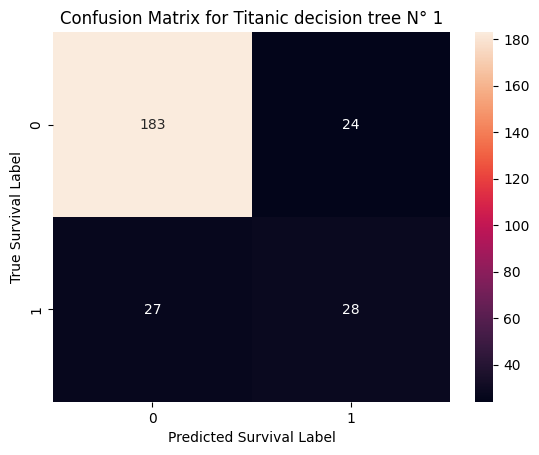

Accuracy: 0.81

Training Tree n°2
Traitement en cours -

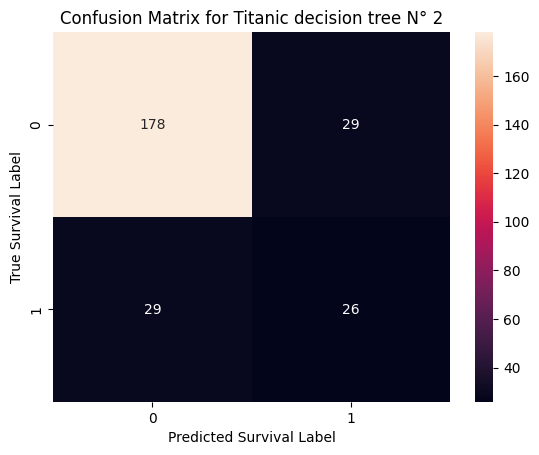

Accuracy: 0.78

Training Tree n°3
Traitement en cours -

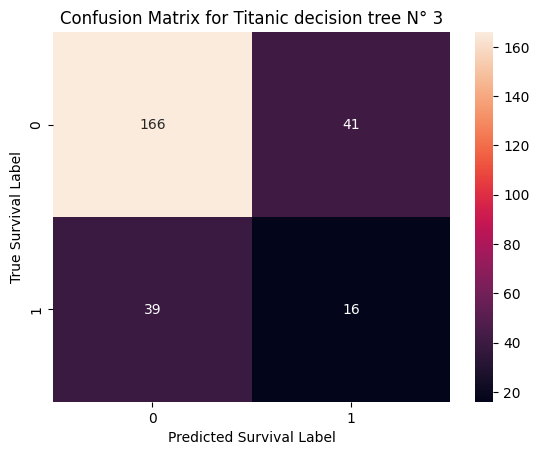

Accuracy: 0.69

Training Tree n°4
Traitement en cours /

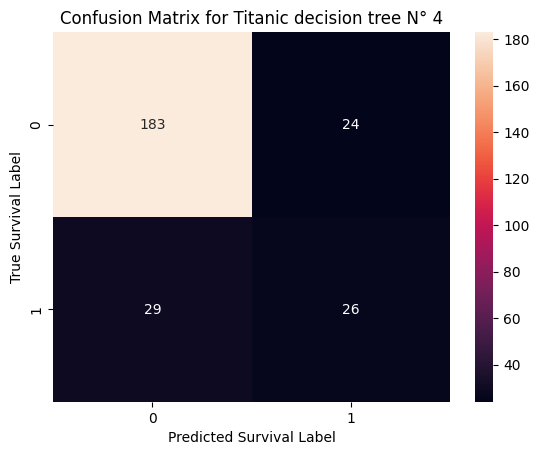

Accuracy: 0.80

Training Tree n°5
Traitement en cours |

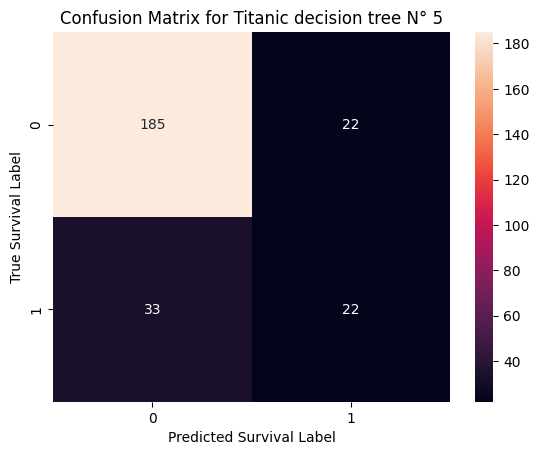

Accuracy: 0.79

Training Tree n°6
Traitement en cours |

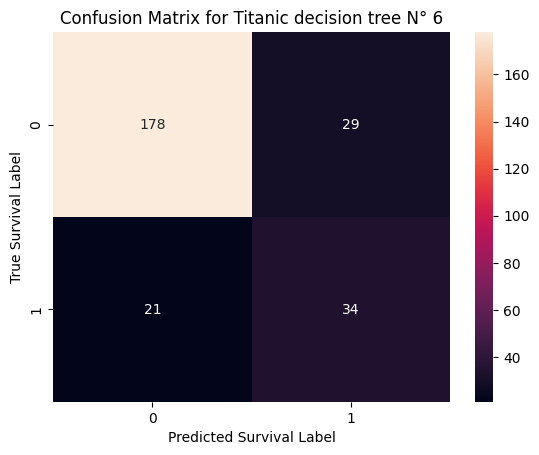

Accuracy: 0.81

Training Tree n°7
Traitement en cours -

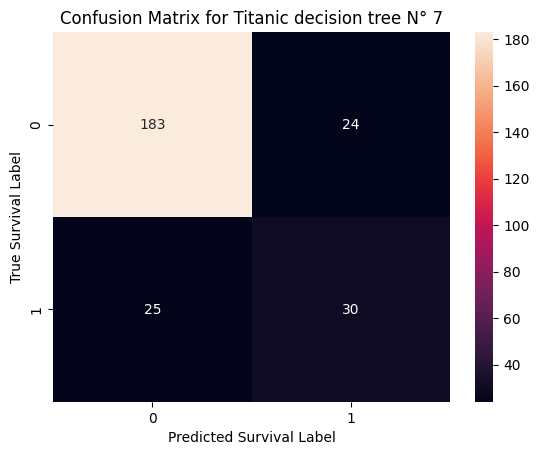

Accuracy: 0.81

Training Tree n°8
Traitement en cours \

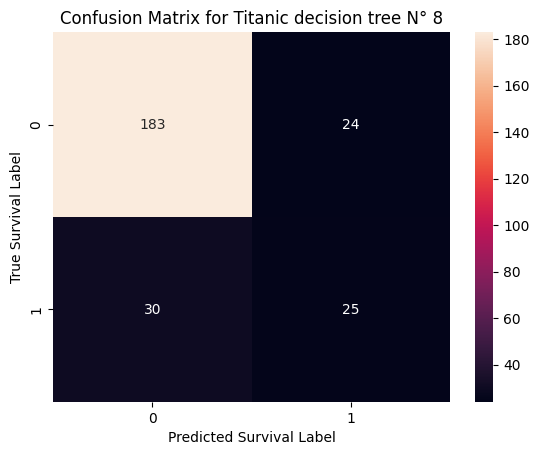

Accuracy: 0.79

Training Tree n°9
Traitement en cours /

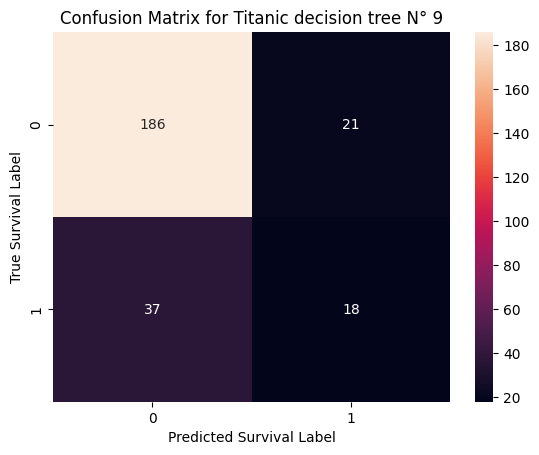

Accuracy: 0.78

Training Tree n°10
Traitement en cours \

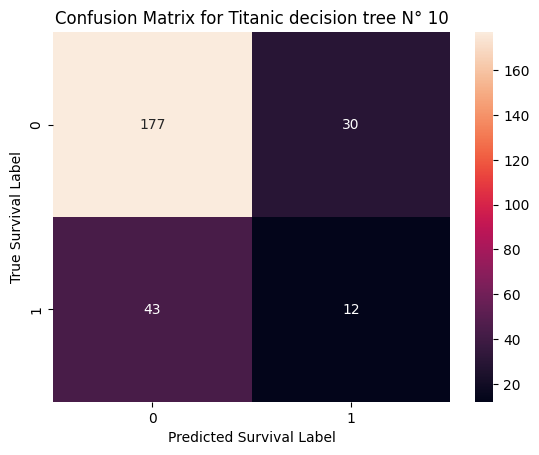

Accuracy: 0.72

 ########################################
 # BAGGING MODEL : CUSTOM RANDOM FOREST #
 ########################################

Training Random Forest of 100 trees
Traitement en cours /0    208
1     54
Traitement en cours -nt64
Traitement en cours /

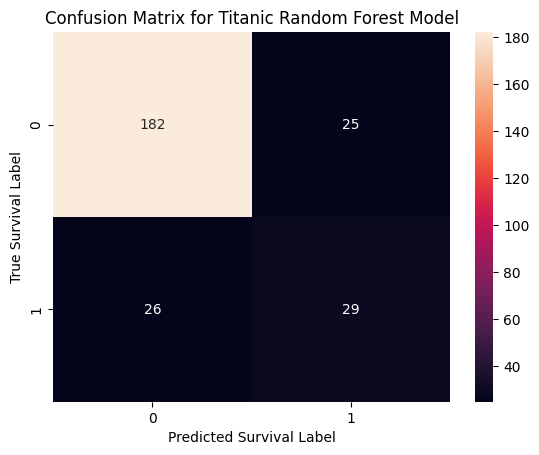

Accuracy: 0.81
Traitement en cours \

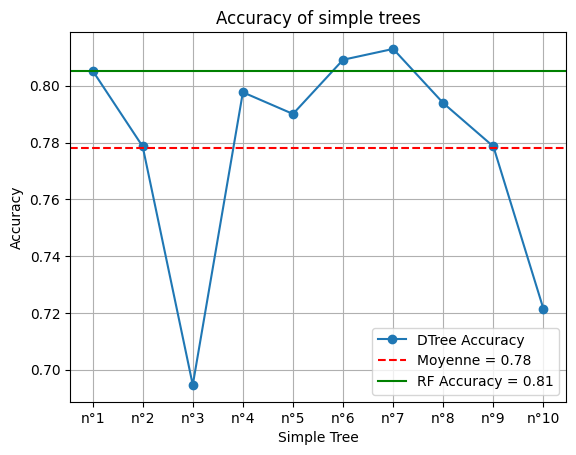

Traitement en cours |
 ###################################################
 # ANALYSIS OF BAGGING VS SIMPLE TREES PERFORMANCE #
 ###################################################

Training 10 custom simple trees
Traitement en cours |Accuracy: 0.81
Traitement en cours -Accuracy: 0.79
Traitement en cours |Accuracy: 0.81
Traitement en cours /Accuracy: 0.81
Traitement en cours \Accuracy: 0.83
Traitement en cours |Accuracy: 0.78
Traitement en cours -Accuracy: 0.79
Traitement en cours /Accuracy: 0.74
Traitement en cours |Accuracy: 0.74
Traitement en cours /Accuracy: 0.72

Training custom random forest of 10 custom simple trees
Traitement en cours |Accuracy: 0.81

Training 20 custom simple trees
Traitement en cours /Accuracy: 0.81
Traitement en cours |Accuracy: 0.81
Traitement en cours \Accuracy: 0.80
Traitement en cours -Accuracy: 0.81
Traitement en cours /Accuracy: 0.80
Traitement en cours |Accuracy: 0.80
Traitement en cours -Accuracy: 0.80
Traitement en cours -Accuracy: 0.75
Traitement e

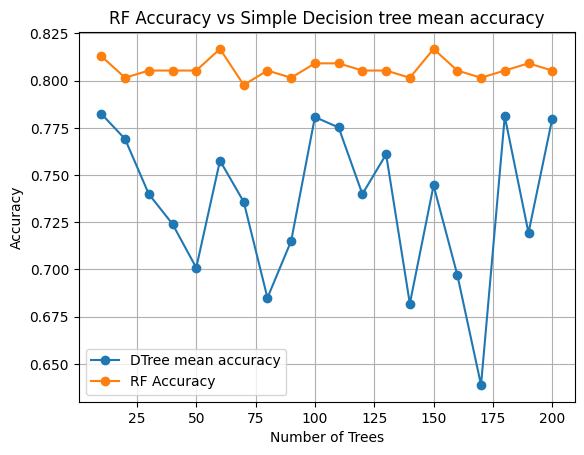

Traitement en cours /

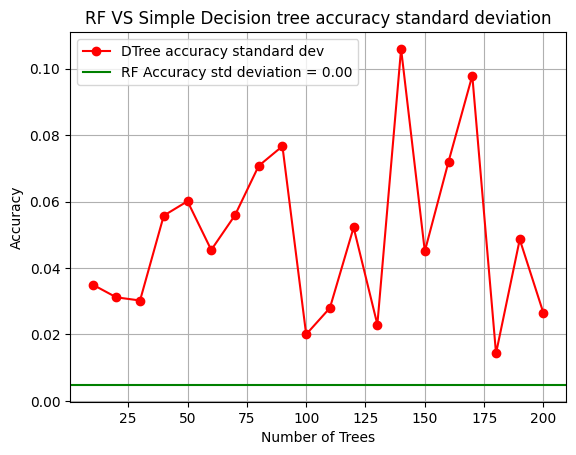

Traitement en cours -
Terminé !


In [5]:
if __name__ == "__main__":

    t = threading.Thread(target=spinner)
    t.start()

    ###############################
    # DATA LOAD AND PREPROCESSING #
    ###############################

    print(
        " ###############################\n \
# DATA LOAD AND PREPROCESSING #\n \
###############################"
    )

    df_init = pd.read_excel("titanic.xlsx", sheet_name="titanic3", header=0)

    print(df_init.head())

    df = df_init[FEATURES + [TARGET]]

    print(df.isnull().sum())

    """df["sex"][df["sex"] == "male"] = 1
    df["sex"][df["sex"] == "female"] = 0"""

    df["sex"] = df["sex"].map({"male": 1, "female": 0})
    df["age"].fillna(df["age"].mean(), inplace=True)
    df["fare"].fillna(df["fare"].mean(), inplace=True)

    print(df.head(10))

    print(df.shape)
    print(df.isnull().sum())
    print(df.dtypes)

    os.makedirs(TREES_OUTPUT_DIR, exist_ok=True)

    #########################
    # TRAIN TEST DATA SPLIT #
    #########################

    print(
        " #########################\n \
# TRAIN TEST DATA SPLIT #\n \
#########################"
    )

    GLOBAL_DEFAULT_CLASS = Counter(df[TARGET]).most_common(1)[0][0]
    train_size = int(0.8 * df.shape[0])
    X_TRAIN = df[:train_size]
    X_TEST = df[train_size:]

    print(f"Test Data")
    print(X_TEST.head(10))

    ################################
    # SIMPLE MODEL : DECISION TREE #
    ################################

    print(
        " ################################\n \
# SIMPLE MODEL : DECISION TREE #\n \
################################"
    )
    simple_dt_names = []
    simple_dt_acc = []

    train_data = X_TRAIN
    for i in range(10):

        simple_dt_names.append(f"n°{i+1}")
        print(f"\nTraining Tree n°{i+1}")
        dt_model = CustomDecisionTree(
            TARGET,
            FEATURES,
            start_depth=TREE_DEFAULT_START_DEPTH,
            max_depth=TREE_DEFAULT_MAX_DEPTH,
        )

        # print(f"Training Data")
        # print(train_data.head(10))

        dt_model.fit(train_data)

        train_data = train_data.sample(frac=1.0, replace=True)

        dot = visualize_tree(dt_model)
        dot.render(
            f"{TREES_OUTPUT_DIR}/simple_tree_{i+1}", format="png", cleanup=False
        )  # Creates tree.png

        Y_Predict = dt_model.predict(X_TEST)
        # print(Y_Predict.value_counts())

        display_cm(
            X_TEST[TARGET],
            Y_Predict,
            df[TARGET],
            f"Confusion Matrix for Titanic decision tree N° {i+1}",
            "Predicted Survival Label",
            "True Survival Label",
        )
        simple_dt_acc.append(get_acc_score(X_TEST[TARGET], Y_Predict))

    moyenne_acc = np.mean(simple_dt_acc)

    ########################################
    # BAGGING MODEL : CUSTOM RANDOM FOREST #
    ########################################

    print(
        "\n ########################################\n \
# BAGGING MODEL : CUSTOM RANDOM FOREST #\n \
########################################"
    )
    num_bagging_trees = 100

    print(f"\nTraining Random Forest of {num_bagging_trees} trees")

    rf_model = CustomRandomForest(
        num_bagging_trees,
        TARGET,
        FEATURES,
        start_depth=TREE_DEFAULT_START_DEPTH,
        max_depth=TREE_DEFAULT_MAX_DEPTH,
    )

    rf_model.fit(X_TRAIN)

    for i, tree in enumerate(rf_model.trees):
        dot = visualize_tree(tree)
        dot.render(
            f"{TREES_OUTPUT_DIR}/tree_{i}", format="png", cleanup=False
        )  # Creates tree.png
        # print(dt_model)

    Y_RF_Predict = rf_model.predict(X_TEST)
    print(Y_RF_Predict.value_counts())

    display_cm(
        X_TEST[TARGET],
        Y_RF_Predict,
        df[TARGET],
        "Confusion Matrix for Titanic Random Forest Model",
        "Predicted Survival Label",
        "True Survival Label",
    )
    rf_acc = get_acc_score(X_TEST[TARGET], Y_RF_Predict)

    # Line plot
    plt.plot(simple_dt_names, simple_dt_acc, marker="o", label=f"DTree Accuracy")
    # Ajout de la ligne de moyenne
    plt.axhline(
        y=moyenne_acc, color="red", linestyle="--", label=f"Moyenne = {moyenne_acc:.2f}"
    )
    plt.axhline(y=rf_acc, color="green", label=f"RF Accuracy = {rf_acc:.2f}")
    plt.title("Accuracy of simple trees")
    plt.xlabel("Simple Tree")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    # Save the figure
    plt.savefig(
        os.path.join(CM_OUTPUT_DIR, f"Accuracy of simple trees.png"),
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    ###################################################
    # ANALYSIS OF BAGGING VS SIMPLE TREES PERFORMANCE #
    ###################################################

    print(
        "\n ###################################################\n \
# ANALYSIS OF BAGGING VS SIMPLE TREES PERFORMANCE #\n \
###################################################"
    )

    simple_dt_nums = []
    simple_dt_acc_means = []
    simple_dt_acc_std_devs = []
    rf_acc_list = []

    for j in range(10, 210, 10):

        train_data = X_TRAIN
        print(f"\nTraining {j} custom simple trees")

        simple_dt_nums.append(j)
        simple_dt_acc = []

        for i in range(j):

            dt_model = CustomDecisionTree(
                TARGET,
                FEATURES,
                start_depth=TREE_DEFAULT_START_DEPTH,
                max_depth=TREE_DEFAULT_MAX_DEPTH,
            )

            dt_model.fit(train_data)

            train_data = train_data.sample(frac=1.0, replace=True)

            Y_Predict = dt_model.predict(X_TEST)
            # print(Y_Predict.value_counts())

            simple_dt_acc.append(get_acc_score(X_TEST[TARGET], Y_Predict))

        moyenne_acc = np.mean(simple_dt_acc)
        acc_std_dev = np.std(simple_dt_acc)

        simple_dt_acc_means.append(moyenne_acc)
        simple_dt_acc_std_devs.append(acc_std_dev)

        print(f"\nTraining custom random forest of {j} custom simple trees")
        rf_model = CustomRandomForest(
            j,
            TARGET,
            FEATURES,
            start_depth=TREE_DEFAULT_START_DEPTH,
            max_depth=TREE_DEFAULT_MAX_DEPTH,
        )

        rf_model.fit(X_TRAIN)

        Y_RF_Predict = rf_model.predict(X_TEST)

        rf_acc = get_acc_score(X_TEST[TARGET], Y_RF_Predict)
        rf_acc_list.append(rf_acc)

    # Line plot
    plt.plot(
        simple_dt_nums, simple_dt_acc_means, marker="o", label=f"DTree mean accuracy"
    )
    plt.plot(simple_dt_nums, rf_acc_list, marker="o", label=f"RF Accuracy")

    plt.title("RF Accuracy vs Simple Decision tree mean accuracy")
    plt.xlabel("Number of Trees")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    # Save the figure
    plt.savefig(
        os.path.join(
            CM_OUTPUT_DIR, f"RF Accuracy vs Simple Decision tree mean accuracy.png"
        ),
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    rf_acc_std_dev = np.std(rf_acc_list)
    

    # Line plot
    plt.plot(
        simple_dt_nums,
        simple_dt_acc_std_devs,
        marker="o",
        color="red",
        label=f"DTree accuracy standard dev",
    )
    plt.axhline(y=rf_acc_std_dev, color="green", label=f"RF Accuracy std deviation = {rf_acc_std_dev:.2f}")
    plt.title("RF VS Simple Decision tree accuracy standard deviation")
    plt.xlabel("Number of Trees")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    # Save the figure
    plt.savefig(
        os.path.join(
            CM_OUTPUT_DIR, f"Simple Decision tree accuracy standard deviation.png"
        ),
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    # Traitement long ici
    time.sleep(5)
    EXECUTION_DONE = True
    t.join()

    print("\nTerminé !")

Traitement en cours | ###############################
 # DATA LOAD AND PREPROCESSING #
 ###############################
Traitement en cours /   pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

       age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.0000      0      0   24160  211.3375       B5        S    2    NaN   
1   0.9167      1      2  113781  151.5500  C22 C26        S   11    NaN   
2   2.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
3  30.0000      1      2  113781  151.5500  C22 C26        S  NaN  135.0  

C:\Users\jrdiouf\AppData\Local\Temp\ipykernel_21748\79284258.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sex"] = df["sex"].map({"male": 1, "female": 0})
C:\Users\jrdiouf\AppData\Local\Temp\ipykernel_21748\79284258.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["age"

Traitement en cours /

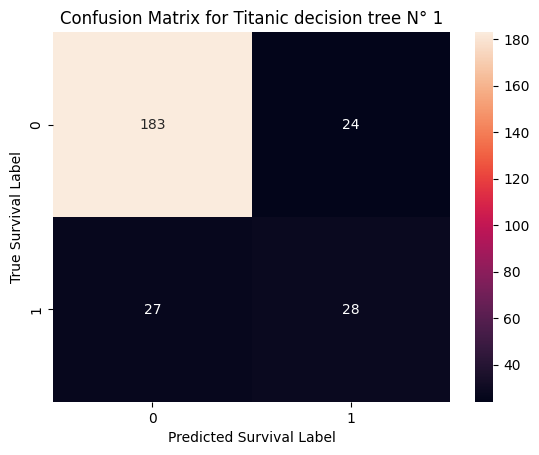

Accuracy: 0.81

Training Tree n°2
Traitement en cours -

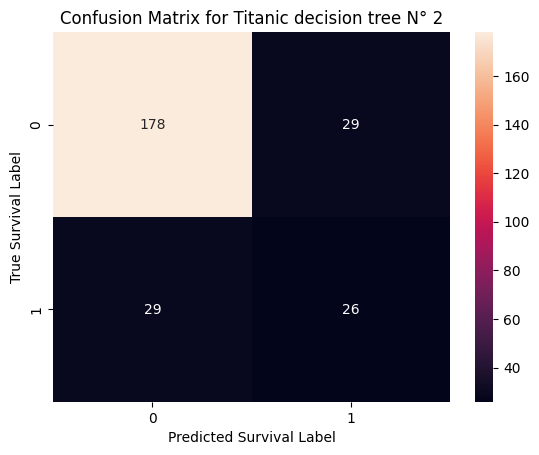

Accuracy: 0.78

Training Tree n°3
Traitement en cours -

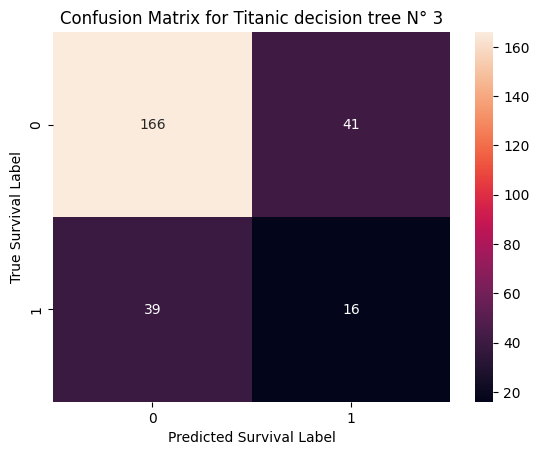

Accuracy: 0.69

Training Tree n°4
Traitement en cours /

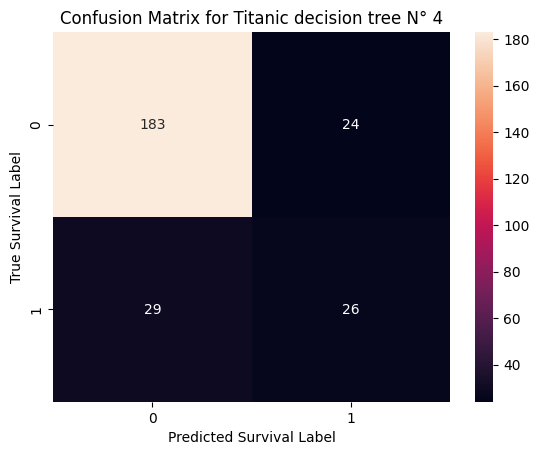

Accuracy: 0.80

Training Tree n°5
Traitement en cours |

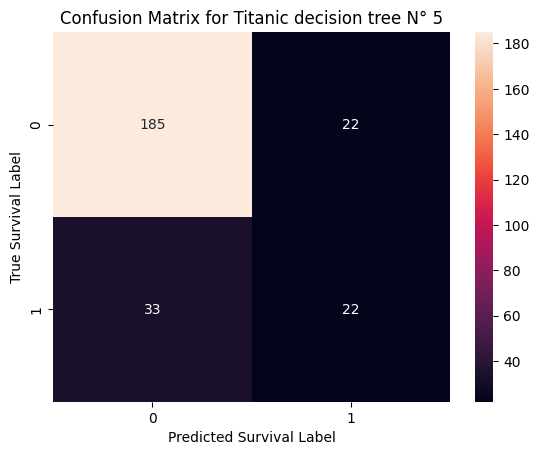

Accuracy: 0.79

Training Tree n°6
Traitement en cours |

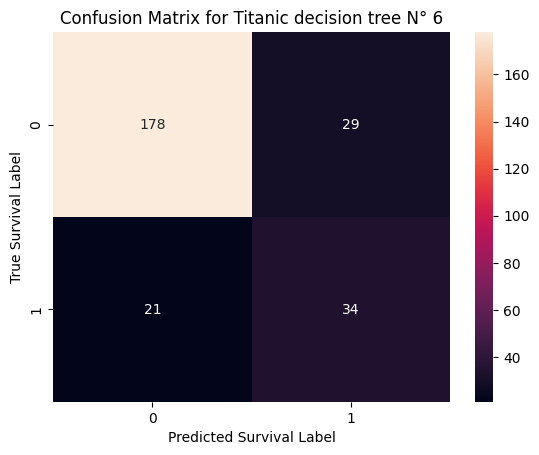

Accuracy: 0.81

Training Tree n°7
Traitement en cours -

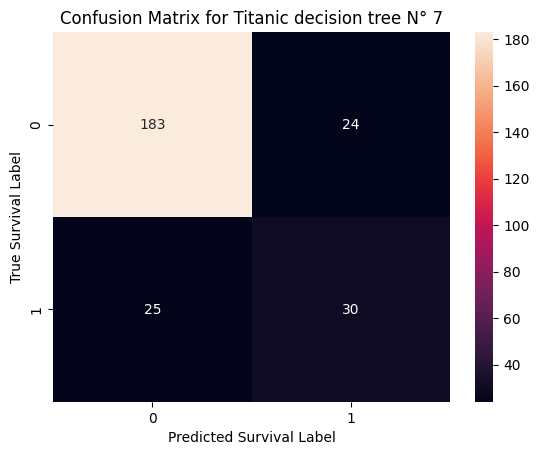

Accuracy: 0.81

Training Tree n°8
Traitement en cours \

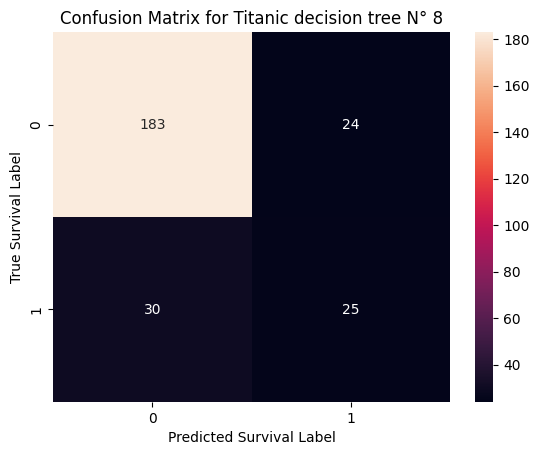

Accuracy: 0.79

Training Tree n°9
Traitement en cours /

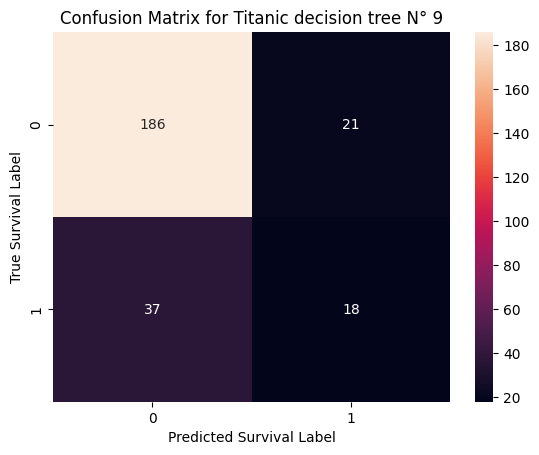

Accuracy: 0.78

Training Tree n°10
Traitement en cours \

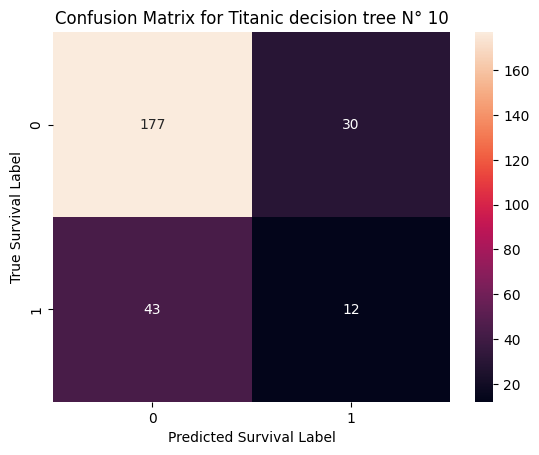

Accuracy: 0.72

 ########################################
 # BAGGING MODEL : CUSTOM RANDOM FOREST #
 ########################################

Training Random Forest of 100 trees
Traitement en cours /0    208
1     54
Traitement en cours -nt64
Traitement en cours /

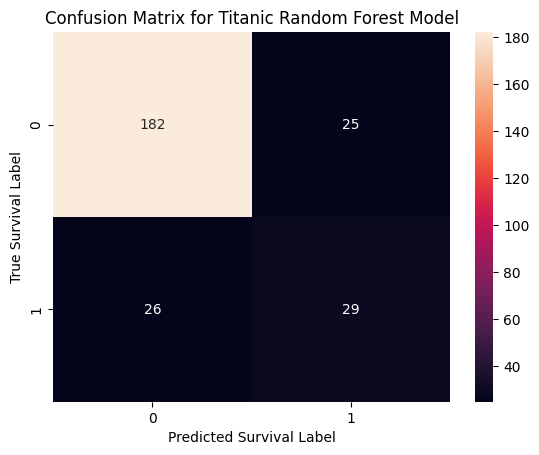

Accuracy: 0.81
Traitement en cours \

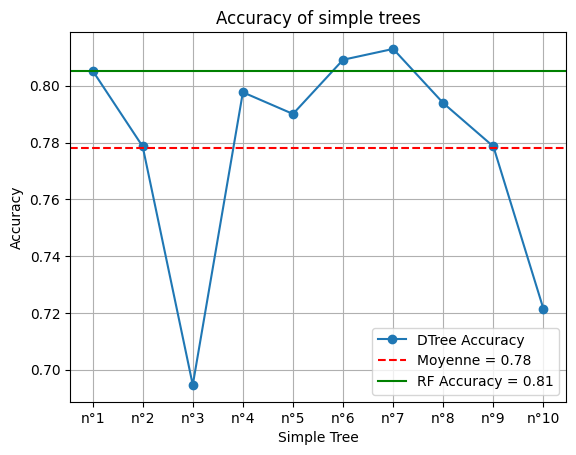

Traitement en cours |
 ###################################################
 # ANALYSIS OF BAGGING VS SIMPLE TREES PERFORMANCE #
 ###################################################

Training 10 custom simple trees
Traitement en cours |Accuracy: 0.81
Traitement en cours -Accuracy: 0.79
Traitement en cours |Accuracy: 0.81
Traitement en cours /Accuracy: 0.81
Traitement en cours \Accuracy: 0.83
Traitement en cours |Accuracy: 0.78
Traitement en cours -Accuracy: 0.79
Traitement en cours /Accuracy: 0.74
Traitement en cours |Accuracy: 0.74
Traitement en cours /Accuracy: 0.72

Training custom random forest of 10 custom simple trees
Traitement en cours |Accuracy: 0.81

Training 20 custom simple trees
Traitement en cours /Accuracy: 0.81
Traitement en cours |Accuracy: 0.81
Traitement en cours \Accuracy: 0.80
Traitement en cours -Accuracy: 0.81
Traitement en cours /Accuracy: 0.80
Traitement en cours |Accuracy: 0.80
Traitement en cours -Accuracy: 0.80
Traitement en cours -Accuracy: 0.75
Traitement e

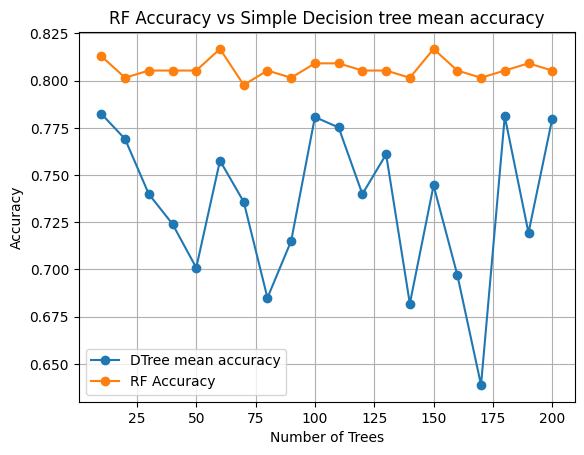

Traitement en cours /

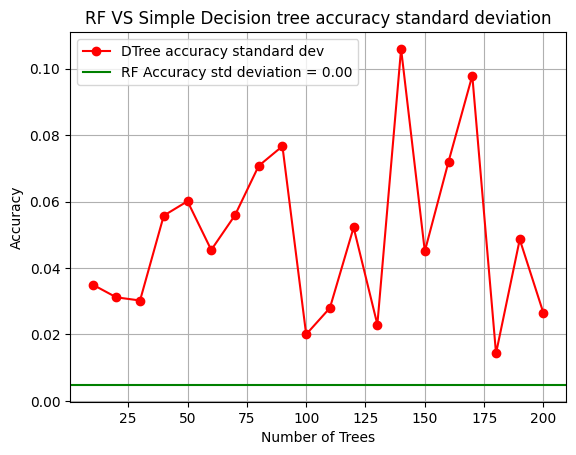

Traitement en cours -
Terminé !


In [ ]:
if __name__ == "__main__":

    t = threading.Thread(target=spinner)
    t.start()

    ###############################
    # DATA LOAD AND PREPROCESSING #
    ###############################

    print(
        " ###############################\n \
# DATA LOAD AND PREPROCESSING #\n \
###############################"
    )

    df_init = pd.read_excel("titanic.xlsx", sheet_name="titanic3", header=0)

    print(df_init.head())

    df = df_init[FEATURES + [TARGET]]

    print(df.isnull().sum())

    """df["sex"][df["sex"] == "male"] = 1
    df["sex"][df["sex"] == "female"] = 0"""

    df["sex"] = df["sex"].map({"male": 1, "female": 0})
    df["age"].fillna(df["age"].mean(), inplace=True)
    df["fare"].fillna(df["fare"].mean(), inplace=True)

    print(df.head(10))

    print(df.shape)
    print(df.isnull().sum())
    print(df.dtypes)

    os.makedirs(TREES_OUTPUT_DIR, exist_ok=True)

    #########################
    # TRAIN TEST DATA SPLIT #
    #########################

    print(
        " #########################\n \
# TRAIN TEST DATA SPLIT #\n \
#########################"
    )

    GLOBAL_DEFAULT_CLASS = Counter(df[TARGET]).most_common(1)[0][0]
    train_size = int(0.8 * df.shape[0])
    X_TRAIN = df[:train_size]
    X_TEST = df[train_size:]

    print(f"Test Data")
    print(X_TEST.head(10))

    ################################
    # SIMPLE MODEL : DECISION TREE #
    ################################

    print(
        " ################################\n \
# SIMPLE MODEL : DECISION TREE #\n \
################################"
    )
    simple_dt_names = []
    simple_dt_acc = []

    train_data = X_TRAIN
    for i in range(10):

        simple_dt_names.append(f"n°{i+1}")
        print(f"\nTraining Tree n°{i+1}")
        dt_model = CustomDecisionTree(
            TARGET,
            FEATURES,
            start_depth=TREE_DEFAULT_START_DEPTH,
            max_depth=TREE_DEFAULT_MAX_DEPTH,
        )

        # print(f"Training Data")
        # print(train_data.head(10))

        dt_model.fit(train_data)

        train_data = train_data.sample(frac=1.0, replace=True)

        dot = visualize_tree(dt_model)
        dot.render(
            f"{TREES_OUTPUT_DIR}/simple_tree_{i+1}", format="png", cleanup=False
        )  # Creates tree.png

        Y_Predict = dt_model.predict(X_TEST)
        # print(Y_Predict.value_counts())

        display_cm(
            X_TEST[TARGET],
            Y_Predict,
            df[TARGET],
            f"Confusion Matrix for Titanic decision tree N° {i+1}",
            "Predicted Survival Label",
            "True Survival Label",
        )
        simple_dt_acc.append(get_acc_score(X_TEST[TARGET], Y_Predict))

    moyenne_acc = np.mean(simple_dt_acc)

    ########################################
    # BAGGING MODEL : CUSTOM RANDOM FOREST #
    ########################################

    print(
        "\n ########################################\n \
# BAGGING MODEL : CUSTOM RANDOM FOREST #\n \
########################################"
    )
    num_bagging_trees = 100

    print(f"\nTraining Random Forest of {num_bagging_trees} trees")

    rf_model = CustomRandomForest(
        num_bagging_trees,
        TARGET,
        FEATURES,
        start_depth=TREE_DEFAULT_START_DEPTH,
        max_depth=TREE_DEFAULT_MAX_DEPTH,
    )

    rf_model.fit(X_TRAIN)

    for i, tree in enumerate(rf_model.trees):
        dot = visualize_tree(tree)
        dot.render(
            f"{TREES_OUTPUT_DIR}/tree_{i}", format="png", cleanup=False
        )  # Creates tree.png
        # print(dt_model)

    Y_RF_Predict = rf_model.predict(X_TEST)
    print(Y_RF_Predict.value_counts())

    display_cm(
        X_TEST[TARGET],
        Y_RF_Predict,
        df[TARGET],
        "Confusion Matrix for Titanic Random Forest Model",
        "Predicted Survival Label",
        "True Survival Label",
    )
    rf_acc = get_acc_score(X_TEST[TARGET], Y_RF_Predict)

    # Line plot
    plt.plot(simple_dt_names, simple_dt_acc, marker="o", label=f"DTree Accuracy")
    # Ajout de la ligne de moyenne
    plt.axhline(
        y=moyenne_acc, color="red", linestyle="--", label=f"Moyenne = {moyenne_acc:.2f}"
    )
    plt.axhline(y=rf_acc, color="green", label=f"RF Accuracy = {rf_acc:.2f}")
    plt.title("Accuracy of simple trees")
    plt.xlabel("Simple Tree")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    # Save the figure
    plt.savefig(
        os.path.join(CM_OUTPUT_DIR, f"Accuracy of simple trees.png"),
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    ###################################################
    # ANALYSIS OF BAGGING VS SIMPLE TREES PERFORMANCE #
    ###################################################

    print(
        "\n ###################################################\n \
# ANALYSIS OF BAGGING VS SIMPLE TREES PERFORMANCE #\n \
###################################################"
    )

    simple_dt_nums = []
    simple_dt_acc_means = []
    simple_dt_acc_std_devs = []
    rf_acc_list = []

    for j in range(10, 210, 10):

        train_data = X_TRAIN
        print(f"\nTraining {j} custom simple trees")

        simple_dt_nums.append(j)
        simple_dt_acc = []

        for i in range(j):

            dt_model = CustomDecisionTree(
                TARGET,
                FEATURES,
                start_depth=TREE_DEFAULT_START_DEPTH,
                max_depth=TREE_DEFAULT_MAX_DEPTH,
            )

            dt_model.fit(train_data)

            train_data = train_data.sample(frac=1.0, replace=True)

            Y_Predict = dt_model.predict(X_TEST)
            # print(Y_Predict.value_counts())

            simple_dt_acc.append(get_acc_score(X_TEST[TARGET], Y_Predict))

        moyenne_acc = np.mean(simple_dt_acc)
        acc_std_dev = np.std(simple_dt_acc)

        simple_dt_acc_means.append(moyenne_acc)
        simple_dt_acc_std_devs.append(acc_std_dev)

        print(f"\nTraining custom random forest of {j} custom simple trees")
        rf_model = CustomRandomForest(
            j,
            TARGET,
            FEATURES,
            start_depth=TREE_DEFAULT_START_DEPTH,
            max_depth=TREE_DEFAULT_MAX_DEPTH,
        )

        rf_model.fit(X_TRAIN)

        Y_RF_Predict = rf_model.predict(X_TEST)

        rf_acc = get_acc_score(X_TEST[TARGET], Y_RF_Predict)
        rf_acc_list.append(rf_acc)

    # Line plot
    plt.plot(
        simple_dt_nums, simple_dt_acc_means, marker="o", label=f"DTree mean accuracy"
    )
    plt.plot(simple_dt_nums, rf_acc_list, marker="o", label=f"RF Accuracy")

    plt.title("RF Accuracy vs Simple Decision tree mean accuracy")
    plt.xlabel("Number of Trees")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    # Save the figure
    plt.savefig(
        os.path.join(
            CM_OUTPUT_DIR, f"RF Accuracy vs Simple Decision tree mean accuracy.png"
        ),
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    rf_acc_std_dev = np.std(rf_acc_list)
    

    # Line plot
    plt.plot(
        simple_dt_nums,
        simple_dt_acc_std_devs,
        marker="o",
        color="red",
        label=f"DTree accuracy standard dev",
    )
    plt.axhline(y=rf_acc_std_dev, color="green", label=f"RF Accuracy std deviation = {rf_acc_std_dev:.2f}")
    plt.title("RF VS Simple Decision tree accuracy standard deviation")
    plt.xlabel("Number of Trees")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    # Save the figure
    plt.savefig(
        os.path.join(
            CM_OUTPUT_DIR, f"RF VS Simple Decision tree accuracy standard deviation.png"
        ),
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    # Traitement long ici
    time.sleep(5)
    EXECUTION_DONE = True
    t.join()

    print("\nTerminé !")